In [1]:
# install packages
!python -m pip install matplotlib
!python -m pip install pandas

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col, desc, countDistinct, year, month, avg, lit, round
from pyspark.sql.types import IntegerType, DoubleType
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("customer_churn").getOrCreate()

### Data Preprocessing

In [4]:
# load the dataset
df = spark.read.csv("data/DS_CaseStudy_Churn_Pred_Data.csv", header=True)

In [5]:
# columns in dataset
df.printSchema()

root
 |-- delay: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- pickup_date: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- driver_rating: string (nullable = true)
 |-- fare: string (nullable = true)
 |-- discount: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- promocode: string (nullable = true)
 |-- taximodelid: string (nullable = true)
 |-- travel_status: string (nullable = true)
 |-- trip_fare: string (nullable = true)
 |-- profile_created: string (nullable = true)
 |-- status_description: string (nullable = true)
 |-- pre_booked: string (nullable = true)
 |-- passengerid: string (nullable = true)
 |-- tripid: string (nullable = true)



In [6]:
# number of rows
df.count()

9004901

In [7]:
# check data
df.show(5)

+-----+------------+-----------+--------+-------------+------+--------+--------------+---------+-----------+-------------+---------+---------------+------------------+----------+-----------+-------+
|delay|created_date|pickup_date|distance|driver_rating|  fare|discount|payment_method|promocode|taximodelid|travel_status|trip_fare|profile_created|status_description|pre_booked|passengerid| tripid|
+-----+------------+-----------+--------+-------------+------+--------+--------------+---------+-----------+-------------+---------+---------------+------------------+----------+-----------+-------+
| null|    20190809|       null|    null|         null|  null|    null|           1.0|     null|          1|           12|     null|       20170223|       Unavailable|         0|     107206|7542464|
| 8.38|    20190701| 20190701.0|   16.49|         null|676.13|     0.0|           1.0|     null|          1|            1|   676.13|       20180201|         Completed|         0|     123034|6044316|
|16.4

In [8]:
# check for na or missing data
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().head()

,delay,created_date,pickup_date,distance,driver_rating,fare,discount,payment_method,promocode,taximodelid,travel_status,trip_fare,profile_created,status_description,pre_booked,passengerid,tripid
0,5077799,0,5077799,5081668,9004901,5081668,5081668,7,7063769,0,0,5081668,0,0,0,0,0


In [9]:
# remove unwanted colums because those columns have more null values
columns_to_drop = ["driver_rating", "promocode"]
df = df.drop(*columns_to_drop)

In [10]:
# check unique count of passenger ids
df.select("passengerid").distinct().count()

518744

In [11]:
# check unique count of trip ids - to check same trip id for different customers
df.select("tripid").distinct().count()

9004901

In [12]:
# check some column data
print(df.select("status_description").distinct().toPandas()["status_description"].to_list())
df.groupBy("status_description").agg(countDistinct("tripid").alias("count")).sort(desc("count")).toPandas().head(7)

['Cancel By Passenger After Accept', 'Concurrent Request', 'Completed', 'Passenger Cancel Before Accept', 'Rejected', 'Driver & Dispatcher Cancellation', 'Unavailable']


,status_description,count
0,Completed,3923005
1,Unavailable,2585817
2,Passenger Cancel Before Accept,1376812
3,Cancel By Passenger After Accept,1012955
4,Driver & Dispatcher Cancellation,85667
5,Concurrent Request,20366
6,Rejected,279


In [13]:
# check relevant status for the description
df.select("travel_status", "status_description").distinct().toPandas().head(7)

,travel_status,status_description
0,13,Concurrent Request
1,11,Rejected
2,4,Cancel By Passenger After Accept
3,12,Unavailable
4,1,Completed
5,8,Driver & Dispatcher Cancellation
6,6,Passenger Cancel Before Accept


In [14]:
# filter only the completed trips - there are more null values for other travel status
df = df.filter(df["travel_status"] == 1)

In [15]:
# check for nulls
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().head()

,delay,created_date,pickup_date,distance,fare,discount,payment_method,taximodelid,travel_status,trip_fare,profile_created,status_description,pre_booked,passengerid,tripid
0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0


In [16]:
# drop nulls
df = df.na.drop()

In [17]:
# check unique count of passenger ids after fitering data
df.select("passengerid").distinct().count()

463296

In [18]:
# check taximodeid column
df.select("taximodelid").distinct().toPandas()["taximodelid"].to_list()

['3', '24', '1', '10', '4', '2']

In [19]:
# created new varibles as follows
df = df.withColumn("trip_created_year", df.created_date.substr(1, 4).cast(IntegerType()))
df = df.withColumn("profile_created_year", df.profile_created.substr(1, 4).cast(IntegerType()))
df = df.withColumn("active_period", col("trip_created_year")-col("profile_created_year"))
df = df.withColumn("trip_created_month", df.created_date.substr(5, 2).cast(IntegerType()))
df = df.withColumn("profile_created_month", df.created_date.substr(5, 2).cast(IntegerType()))

In [20]:
# check some data
df.select("trip_created_year").distinct().show()
df.select("profile_created_year").distinct().show()
df.select("trip_created_month").distinct().show()

+-----------------+
|trip_created_year|
+-----------------+
|             2019|
+-----------------+

+--------------------+
|profile_created_year|
+--------------------+
|                2018|
|                2015|
|                2019|
|                2016|
|                2017|
+--------------------+

+------------------+
|trip_created_month|
+------------------+
|                 6|
|                 8|
|                 7|
+------------------+



In [21]:
# change data type 
df = df.withColumn("delay", df["delay"].cast(DoubleType()))
df = df.withColumn("distance", df["distance"].cast(DoubleType()))
df = df.withColumn("fare", df["fare"].cast(DoubleType()))
df = df.withColumn("discount", df["discount"].cast(DoubleType()))
df = df.withColumn("trip_fare", df["trip_fare"].cast(DoubleType()))

### Exploratory Analysis

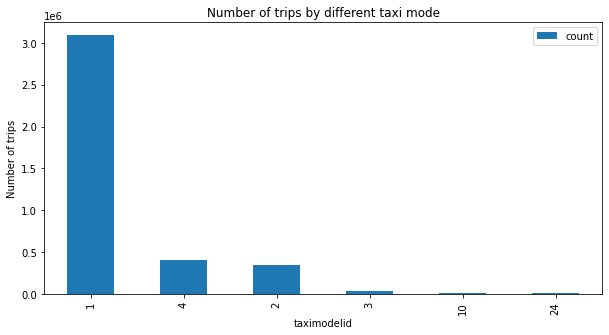

In [22]:
# plot for taximodeid data
taxi_mode = df.groupBy("taximodelid").agg(countDistinct("tripid").alias("count")).sort(["count"], ascending=False)\
.toPandas()
# remove null values
taxi_mode = taxi_mode.dropna()
# bar plot
taxi_mode.plot(x="taximodelid", y="count", kind='bar', figsize=(10,5))
plt.xlabel("taximodelid")
plt.ylabel("Number of trips")
plt.title("Number of trips by different taxi mode")
plt.show()

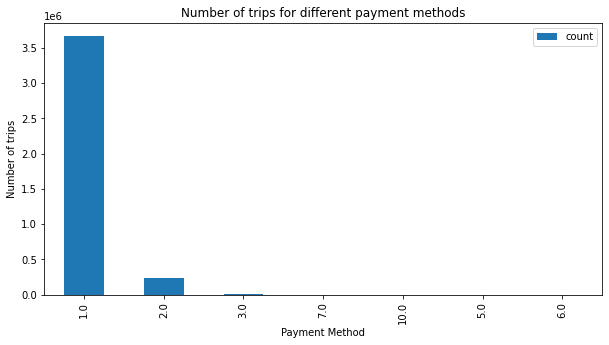

In [23]:
# plot for payment methods
payment_methods = df.groupBy("payment_method").agg(countDistinct("tripid").alias("count"))\
.sort(["count"], ascending=False).toPandas()
# remove null values
payment_methods = payment_methods.dropna()
# bar plot
payment_methods.plot(x="payment_method", y="count", kind='bar', figsize=(10,5))
plt.xlabel("Payment Method")
plt.ylabel("Number of trips")
plt.title("Number of trips for different payment methods")
plt.show()

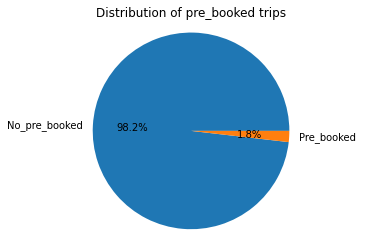

In [24]:
# pie chart for pre_booked
pre_booked_df = df.groupBy("pre_booked").agg(countDistinct("tripid").alias("count")).toPandas()
plt.pie(pre_booked_df["count"],labels=["No_pre_booked", "Pre_booked"],autopct='%1.1f%%')
plt.title("Distribution of pre_booked trips")
plt.axis("equal")
plt.show()

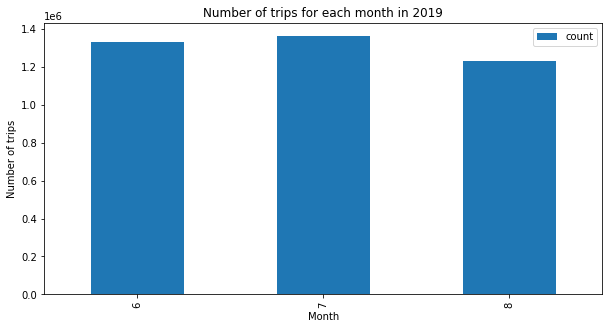

In [25]:
# plot for monthly trips
month_trips = df.groupBy("trip_created_month").agg(countDistinct("tripid").alias("count"))\
.sort(["trip_created_month"], ascending=True).toPandas()
# bar plot
month_trips.plot(x="trip_created_month", y="count", kind='bar', figsize=(10,5))
plt.xlabel("Month")
plt.ylabel("Number of trips")
plt.title("Number of trips for each month in 2019")
plt.show()

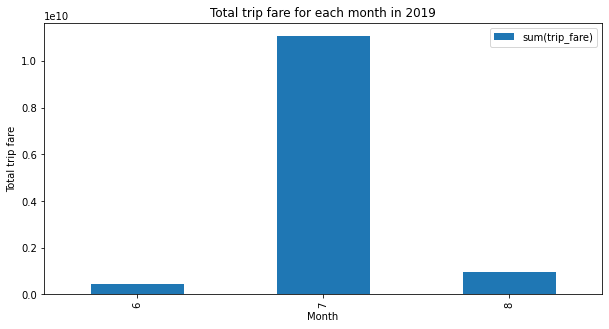

In [26]:
# plot for monthly fare
month_fair_df = df.filter(df["pre_booked"]==0).groupBy("trip_created_month")\
.sum("trip_fare").sort(["trip_created_month"], ascending=True).toPandas()
# bar plot
month_fair_df.plot(x="trip_created_month", y="sum(trip_fare)", kind='bar', figsize=(10,5))
plt.xlabel("Month")
plt.ylabel("Total trip fare")
plt.title("Total trip fare for each month in 2019")
plt.show()

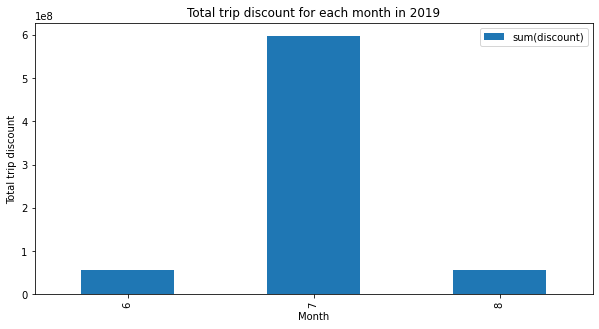

In [27]:
# plot for monthly discount
month_fair_df = df.filter(df["pre_booked"]==0).groupBy("trip_created_month")\
.sum("discount").sort(["trip_created_month"], ascending=True).toPandas()
# bar plot
month_fair_df.plot(x="trip_created_month", y="sum(discount)", kind='bar', figsize=(10,5))
plt.xlabel("Month")
plt.ylabel("Total trip discount")
plt.title("Total trip discount for each month in 2019")
plt.show()

### Feature Engineering

In [28]:
# filter variables
df = df.select("passengerid", "tripid", "profile_created", "created_date", "profile_created_month",
              "trip_created_month", "active_period", "delay", "distance", "fare", "discount", "trip_fare")

In [29]:
# get each month total trips
df_new = df.groupBy(["passengerid", "profile_created_month", "trip_created_month", "active_period", "delay", 
                     "distance", "fare", "discount", "trip_fare"]).agg(countDistinct("tripid").alias("trip_count"))

In [30]:
# check data
df_new.show(5)

+-----------+---------------------+------------------+-------------+-----+--------+------+--------+---------+----------+
|passengerid|profile_created_month|trip_created_month|active_period|delay|distance|  fare|discount|trip_fare|trip_count|
+-----------+---------------------+------------------+-------------+-----+--------+------+--------+---------+----------+
|     215220|                    7|                 7|            0| 5.43|   10.16|406.97|     0.0|   406.97|         1|
|     220276|                    6|                 6|            0| 3.63|    2.58|119.12|     0.0|   119.12|         1|
|     242871|                    6|                 6|            3| 6.05|   11.92|460.68|     0.0|   460.68|         1|
|     271529|                    8|                 8|            1|14.67|   11.14|472.56|     0.0|   472.56|         1|
|     292127|                    6|                 6|            2|  5.1|    2.22|115.48|     0.0|   115.48|         1|
+-----------+-------------------

In [31]:
# columns in filtered dataset
df_new.printSchema()

root
 |-- passengerid: string (nullable = true)
 |-- profile_created_month: integer (nullable = true)
 |-- trip_created_month: integer (nullable = true)
 |-- active_period: integer (nullable = true)
 |-- delay: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- trip_fare: double (nullable = true)
 |-- trip_count: long (nullable = false)



In [32]:
# number of rows
df_new.count()

3922873

In [33]:
# check unique count of passenger ids after fitering data
df_new.select("passengerid").distinct().count()

463296

In [34]:
# remove newly created customers(porfile created in August) - there are few trips when its created in August
df_new = df_new.filter(~((df_new["active_period"] == 0) & (df_new["profile_created_month"] == 8)))

In [35]:
# check unique count of passenger ids after fitering data
df_new.select("passengerid").distinct().count()

409353

In [36]:
# check min, max and average trips for each month
df_new.groupBy("trip_created_month").min("trip_count").show()
df_new.groupBy("trip_created_month").max("trip_count").show()
df_new.groupBy("trip_created_month").avg("trip_count").show()

+------------------+---------------+
|trip_created_month|min(trip_count)|
+------------------+---------------+
|                 6|              1|
|                 8|              1|
|                 7|              1|
+------------------+---------------+

+------------------+---------------+
|trip_created_month|max(trip_count)|
+------------------+---------------+
|                 6|              7|
|                 8|              3|
|                 7|              6|
+------------------+---------------+

+------------------+------------------+
|trip_created_month|   avg(trip_count)|
+------------------+------------------+
|                 6|1.0000473894434374|
|                 8| 1.000018126652314|
|                 7|1.0000322482056438|
+------------------+------------------+



### Problem statement(how to define a customer has ‘churned’)

#### If there are trips for each customer last month(August), there is no dormant/churn for next month. 

In [37]:
# filter passengers who went trips last month(August)
df_new1 = df_new.filter(df_new["trip_created_month"] == 8).select("passengerid").drop_duplicates()
# add new column as churn and marked values as "No" churn
df_new1 = df_new1.withColumn("churn",  lit("No"))

In [38]:
# check data for above filtered set
df_new1.show(5)
print(df_new1.select("passengerid").distinct().count())
print(df_new1.count())

+-----------+-----+
|passengerid|churn|
+-----------+-----+
|      36526|   No|
|     420275|   No|
|     379041|   No|
|        675|   No|
|     392800|   No|
+-----------+-----+
only showing top 5 rows

160110
160110


In [39]:
# group data based on passenger id and get sum of each column
df_new2 = df_new.groupBy("passengerid").sum("trip_count","delay", "distance", "fare", "discount", "trip_fare")

In [40]:
# round off values of columns
df_new2 = df_new2.withColumn("sum_delay", round(col("sum(delay)"),2))
df_new2 = df_new2.withColumn("sum_distance", round(col("sum(distance)"),2))
df_new2 = df_new2.withColumn("sum_fare", round(col("sum(fare)"),2))
df_new2 = df_new2.withColumn("sum_discount", round(col("sum(discount)"),2))
df_new2 = df_new2.withColumn("sum_trip_fare", round(col("sum(trip_fare)"),2))
# rename a column
df_new2 = df_new2.withColumnRenamed("sum(trip_count)", "total_trip_count")

# filter data
df_new2 = df_new2.select("passengerid", "total_trip_count", "sum_delay", "sum_distance","sum_fare",
                         "sum_discount", "sum_trip_fare")

In [41]:
# check data
df_new2.show(5)
print(df_new2.select("passengerid").distinct().count())
print(df_new2.count())

+-----------+----------------+---------+------------+--------+------------+-------------+
|passengerid|total_trip_count|sum_delay|sum_distance|sum_fare|sum_discount|sum_trip_fare|
+-----------+----------------+---------+------------+--------+------------+-------------+
|      60070|               7|    24.17|       42.16|  1705.0|         0.0|       1705.0|
|     264845|               5|   103.03|       82.16| 4209.72|         0.0|      4209.72|
|     480004|               5|    60.37|       42.98| 2366.28|       200.0|      2166.27|
|     179486|              39|   313.96|      116.96| 5962.37|        50.0|      5912.37|
|        467|               9|   118.38|       75.35| 3939.15|         0.0|      3939.15|
+-----------+----------------+---------+------------+--------+------------+-------------+
only showing top 5 rows

409353
409353


In [42]:
df = df.filter(~((df["active_period"] == 0) & (df["profile_created_month"] == 8)))
# get total trip count for August, June and July 
df_new_august = df.filter(df["trip_created_month"] == 8).groupBy("passengerid").agg(countDistinct("tripid")\
                                                                                    .alias("august_trip_count"))
df_new_july = df.filter(df["trip_created_month"] == 7).groupBy("passengerid").agg(countDistinct("tripid")\
                                                                                      .alias("july_trip_count"))
df_new_june = df.filter(df["trip_created_month"] == 6).groupBy("passengerid").agg(countDistinct("tripid")\
                                                                                      .alias("june_trip_count"))

In [43]:
# check data
print(df_new_august.count())
print(df_new_july.count())
print(df_new_june.count())

160110
286931
280029


In [44]:
# merge data 
final_df = df_new2.join(df_new1, on=["passengerid"], how="left")
final_df = final_df.join(df_new_august, on=["passengerid"], how="left")
final_df = final_df.join(df_new_july, on=["passengerid"], how="left")
final_df = final_df.join(df_new_june, on=["passengerid"], how="left")
# fill null values of churn column as "Yes" 
final_df = final_df.fillna("Yes", subset=["churn"])
# fill null values as 0
final_df = final_df.fillna(0, subset=["august_trip_count", "july_trip_count", "june_trip_count"])

In [45]:
# check data
final_df.show(5)
print(final_df.count())
print(final_df.select("passengerid").distinct().count())

+-----------+----------------+---------+------------+--------+------------+-------------+-----+-----------------+---------------+---------------+
|passengerid|total_trip_count|sum_delay|sum_distance|sum_fare|sum_discount|sum_trip_fare|churn|august_trip_count|july_trip_count|june_trip_count|
+-----------+----------------+---------+------------+--------+------------+-------------+-----+-----------------+---------------+---------------+
|     100010|              28|   279.58|      205.86|10264.76|         0.0|     10264.76|   No|               13|              9|              6|
|     100140|               2|     8.88|        6.68|  315.55|         0.0|       315.55|  Yes|                0|              2|              0|
|     100227|               5|    30.77|       29.29| 1187.39|       150.0|      1037.37|  Yes|                0|              3|              2|
|     100263|               2|     0.58|        1.34|  113.82|         0.0|       113.82|  Yes|                0|           

In [46]:
# check data distibution for churn column
final_df.groupBy("churn").agg(countDistinct("passengerid").alias("count")).toPandas().head()

,churn,count
0,No,160110
1,Yes,249243


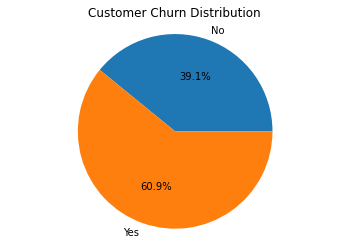

In [47]:
# draw a pie chart
churn_df = final_df.groupBy("churn").agg(countDistinct("passengerid").alias("count")).toPandas()
plt.pie(churn_df["count"],labels=["No","Yes"],autopct='%1.1f%%')
plt.title("Customer Churn Distribution")
plt.axis("equal")
plt.show()

In [48]:
# write filtered data into a csv
final_df.toPandas().to_csv("data/filetered_churn_data.csv")